# Introduction

In this post, I train Karpathy's __[nanoGPT](https://johncollinsai-nanogpt-voqqf4ls3a-as.a.run.app/)__ on high-frequency (tick-by-tick) data for __[AAPL](https://www.google.com/search?q=aapl&oq=AAPL&aqs=chrome.0.0i512l5j69i61l3.1590j1j9&sourceid=chrome&ie=UTF-8)__ and __[JPM](https://www.google.com/search?q=jpm+stock+price&oq=JPM+stock+pri&aqs=chrome.0.0i512j69i57j0i512l8.4577j1j9&sourceid=chrome&ie=UTF-8)__. I want to see how nanoGPT performs as a volatility predictor.  I also want to explore the use of LLMs for tasks, in this case volatility prediction, that are typically performed by models more specific to finance.  In the case of volatility prediction, the established model classes include stochastic volatility models such as the __[MSM](https://github.com/johncollinsai/markov-switching-multifractal)__ of Calvet & Fisher, ARCH and GARCH, and Jump Diffusion models. More recently deep learning has been applied to volatility prediction and this __[post](https://johncollinsai-deep-learning-finance-voqqf4ls3a-as.a.run.app/)__ describes these developments in some detail. However, the application of LLMs to volatility prediction appears to be quite novel and the use of nanoGPT provides a great basis for an under-the-hood examination.

I begin with __[my earlier implementation of Karpathy's nanoGPT](https://github.com/johncollinsai/nanogpt)__. Starting with a very simple bigram language model, following Karpathy, I define and build a transformer piece by piece. Then I train it on a rigorously prepared tick-by-tick price dataset. In order to negate or reduce the impact of microstructure noise, and in particular Bid-Ask bounce, I compute a weighted mid-price using the CloseBid and CloseAsk prices and sizes. I discuss microstructure noise, Bid-Ask bounce, weighted mid-price, and my motivation for using it, in detail in my post __[high frequency data](https://johncollinsai-high-frequency-data-voqqf4ls3a-as.a.run.app)__.  I obtain returns from the WMP and, for tractability, log returns.

My code for this post is arranged in following python files:

* volgpt_data.py imports the OHLC data from NYSE TAQ and preprocesses it

* [BRIEFLY DESCRIBE THE REST OF THE FUNCTIONS IN THE ORDER IN WHICH THEY ARE USED]

I use an NVIDIA GeForce RTX 3080 Ti Laptop GPU and a deep learning framework that includes PyTorch, CUDA, cuDNN, and NVIDIA Drivers, on Ubuntu 22.04 LTS.  Source code as always may be found on __[my GitHub](https://github.com/johncollinsai/nanogpt)__.

#### Import high-frequency data, prepare, describe and visualize it

device: cuda
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
df_data_AAPL.shape:  (533860, 8)
df_data_JPM.shape:  (537011, 8)
no missing_rows_AAPL rows with missing values
no missing_rows_JPM rows with missing values

Descriptive statistics for AAPL:  
Number of observations =  443967 
Minimum, Maximum =  (-4.939047619047614, 5.117424242424221) 
Mean = 0.00012 
Variance = 0.02422 
Standard deviation = 0.15563 
Skewness = -0.01287 
Kurtosis = 74.23754 

Descriptive statistics for JPM:  
Number of observations =  331727 
Minimum, Maximum =  (-5.124583333333334, 5.111818181818194) 
Mean = 0.00010 
Variance = 0.02372 
Standard deviation = 0.15400 
Skewness = 0.14252 
Kurtosis = 165.47317


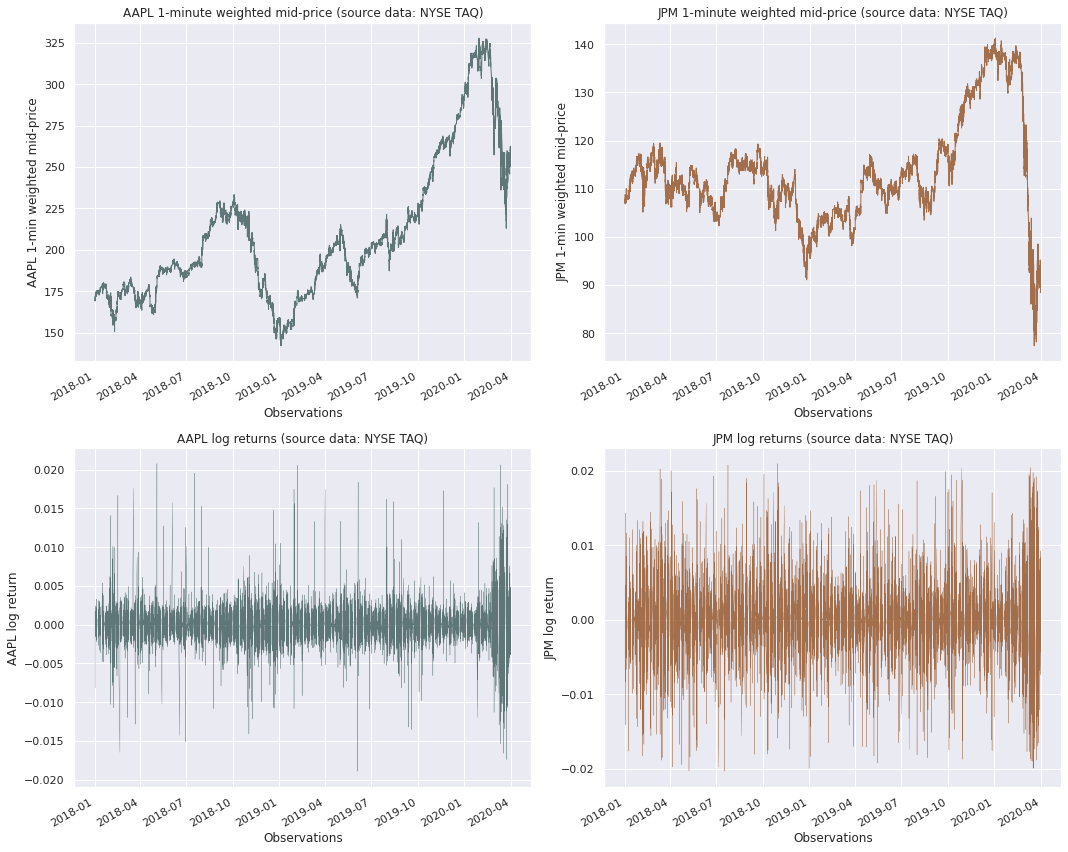

In [1]:
from volgpt_describe import volgpt_import, volgpt_describe # import the high frequency OHLC data from NYSE TAQ, prepare it
df_data_AAPL, df_data_JPM, AAPL_rr, JPM_rr, AAPL_lr, JPM_lr, AAPL_stats, JPM_stats, device = volgpt_import(dp=8) # set dp
volgpt_describe(AAPL_stats, JPM_stats, df_data_AAPL, df_data_JPM, AAPL_lr, JPM_lr) # describe and visualize the data

#### Train NanoGPT and generate new high-frequency data

The basic mechanics here are:

* The decode() function is used to convert the output produced by m.generate() from the list of token IDs to a human-readable string. The output of m.generate() is a tensor of long integers, which is converted to a Python list with .tolist(). Then, the resulting list is passed as an argument to decode(), which uses volGPT's trained bigram language model to convert the token IDs to the corresponding text representations. Finally, the output of decode() is assigned to the variable generated_text.

* I generate 50k tokens, and then decode the tokens into a string. The output string, pred, contains a list of financial data points, including stock names (e.g., AAPL, JPM), timestamps, and the various numerical values. Each row of data starts with the stock symbol (e.g., AAPL or JPM), followed by a timestamp. After the timestamp, the other data are separated by commas. 

* Note that I generate 50k tokens because I need a lot of generated text to get datetimestamps that align between the generated high frequency data and the real high frequency data

In [2]:
from volgpt import train_and_generate # use volgpt to generate text
max_new_tokens=50000 # Set max_new_tokens sufficiently high that date-time stamps match the original data
text_file_path = 'df_data_AAPL.txt' # specify the path to the text file
test_data, generated_text, itos = train_and_generate(text_file_path, # obtain test_data and generated_text
                                                     max_iters=5000, 
                                                     learning_rate=1e-3, 
                                                     device=device, 
                                                     max_new_tokens=max_new_tokens)
generated_text_lines = generated_text.splitlines() # print the first 10 lines of generated text
for line in generated_text_lines[:10]:
    print(line)

0.207149 M parameters
step 0: train loss 3.9567, val loss 3.9870
step 100: train loss 1.5692, val loss 1.6165
step 200: train loss 1.1567, val loss 1.2101
step 300: train loss 1.0078, val loss 1.1070
step 400: train loss 0.9450, val loss 1.0320
step 500: train loss 0.8930, val loss 0.9943
step 600: train loss 0.8633, val loss 1.0023
step 700: train loss 0.8644, val loss 0.9822
step 800: train loss 0.8420, val loss 0.9506
step 900: train loss 0.8282, val loss 0.9751
step 1000: train loss 0.8299, val loss 0.9663
step 1100: train loss 0.8189, val loss 0.9463
step 1200: train loss 0.8181, val loss 0.9540
step 1300: train loss 0.8099, val loss 0.9491
step 1400: train loss 0.7990, val loss 0.9525
step 1500: train loss 0.8061, val loss 0.9411
step 1600: train loss 0.7957, val loss 0.9379
step 1700: train loss 0.7976, val loss 0.9576
step 1800: train loss 0.7911, val loss 0.9256
step 1900: train loss 0.7831, val loss 0.9520
step 2000: train loss 0.7747, val loss 0.9206
step 2100: train loss 0.

#### Clean generated high-frequency data

* My clean_data function takes in a text_data string containing preds in CSV format and column names as a list. I clean the data by removing invalid rows, and convert the data types of the columns. The function returns a tuple of three values: the original DataFrame, the cleaned DataFrame, and a list of indices of invalid rows.

* It is essential to clean and preprocess test_data in the same way that I did for the generated predictions. This will ensure that the data is in a consistent format, and I can compare the model's predictions with the actual data accurately.

* I also align the timing of the predictions and the test data. If the model's predictions and the test data have different time steps, it is not possible to accurately calculate the MSE and MAE; I therefore ensure that both datasets are aligned in terms of their time steps before calculating the performance metrics.

In [3]:
from volgpt_clean_data import clean_data # clean the data
df, df_clean, invalid_rows = clean_data(generated_text)

Original DataFrame: 
           DateTimeIndex Ticker   CloseBidSize  CloseAskSize CloseBidPrice CloseAskPrice WeightedMidPrice            rr           lr
0    2018-02-13 26:32:00   AAPL   200.00000000  400.00000000  204.21000000  204.04000000     204.21428571   -0.02969020  -0.00027311
1    2019-01-26 05:41:00   AAPL  2000.00000000  100.00000000  164.48000000  164.45000000     164.45000000  164.40268571  -0.01615424
2    2018-08-08 04:51:00   AAPL   100.00000000  400.00000000  193.96000000  193.92000000     193.40000000  193.57500000   0.00166667
3    2019-09-27 14:26:00   AAPL   900.00000000  300.00000000  198.51000000  198.47000000     198.63272727    0.00394042   0.00037080
4    2018-08-17 16:46:00   AAPL   300.00000000  100.00000000  188.85000000  188.96000000     188.85000000    0.00181818   0.00001014
..                   ...    ...            ...           ...           ...           ...              ...           ...          ...
443  2018-05-29 18:22:00   AAPL  9000.00000000  

#### Evaluate the model: MSE, MAE, and paired t-test 

I evaluate the accuracy of the raw return and log return predictions by the model using Mean Squared Error (MSE) and Mean Absolute Error (MAE). To briefly recap:

* Mean Squared Error (MSE) measures the average squared difference between the predicted values and the actual values. A lower MSE indicates better accuracy.

* Mean Absolute Error (MAE) measures the average absolute difference between the predicted values and the actual values. This metric is less sensitive to outliers compared to MSE.

I perform a hypothesis test to compare the performance of two models or evaluate the significance of your model's errors, you can use a paired t-test.

* The paired t-test helps determine if there is a significant difference between the true values and the predicted values. If the p-value is small (typically below 0.05), it suggests that the difference is significant, and the model's errors are not likely due to random chance.


In [4]:
from volgpt_stats import volgpt_stats # evaluate the model
generated_clean, test_data_clean, merged_data, rr_mae, rr_mse, lr_mae, lr_mse, raw_t_stat, raw_p_value, log_t_stat, log_p_value = volgpt_stats(generated_text, test_data, itos)

Original DataFrame: 
           DateTimeIndex Ticker   CloseBidSize  CloseAskSize CloseBidPrice CloseAskPrice WeightedMidPrice            rr           lr
0    2018-02-13 26:32:00   AAPL   200.00000000  400.00000000  204.21000000  204.04000000     204.21428571   -0.02969020  -0.00027311
1    2019-01-26 05:41:00   AAPL  2000.00000000  100.00000000  164.48000000  164.45000000     164.45000000  164.40268571  -0.01615424
2    2018-08-08 04:51:00   AAPL   100.00000000  400.00000000  193.96000000  193.92000000     193.40000000  193.57500000   0.00166667
3    2019-09-27 14:26:00   AAPL   900.00000000  300.00000000  198.51000000  198.47000000     198.63272727    0.00394042   0.00037080
4    2018-08-17 16:46:00   AAPL   300.00000000  100.00000000  188.85000000  188.96000000     188.85000000    0.00181818   0.00001014
..                   ...    ...            ...           ...           ...           ...              ...           ...          ...
443  2018-05-29 18:22:00   AAPL  9000.00000000  

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

#### Results [NEED TO BE UPDATED]

* The merged data shows the predicted/generated returns (rr_generated, lr_generated) and the actual/test returns (rr_test, lr_test). It is important to note that the generated data has a date range from 2010-07-29 to 2030-09-07, while the test data has a date range from 2018-01-02 to 2020-02-19. This means that the generated data covers a broader time range and might have different market conditions than the test data.

* Raw returns MSE and MAE values, as well as log returns MSE and MAE values, are still relatively low. This indicates that the prediction model is fairly accurate on average. However, to better assess the performance of the model, it would be helpful to compare these metrics against a suitable benchmark, such as a naive forecasting model or other established models in the field.

* Paired t-test results: With the additional context, it's worth noting that the p-values for both raw returns and log returns are still greater than the commonly used significance level of 0.05. This means there is no strong evidence to reject the null hypothesis that the true and predicted values have the same mean. This suggests that the prediction model is not significantly different from the true values.

* In summary, the results still indicate that the prediction model is performing reasonably well in terms of predicting raw returns and log returns. However, it's crucial to compare these results with a suitable baseline or benchmark and consider the specific context and use case you are working on to determine whether they are good enough. Additionally, you may want to explore other performance metrics and perform further analysis, such as comparing the model's performance during different market conditions, to better assess the model's robustness and applicability.

#### Conclusions

* The results suggest that a text-to-text LLM trained on high-frequency OHLC data can perform well as a volatility predictor, at least as well as the number-to-number asset pricing models traditionally used for this task.

* What this work appears to show is that it is possible to convert numbers to text and train a LLM to understand the patterns in the data that enable forward prediction of volatility with a level accuracy that is comparible if not better than asset pricing models built specifically for this and similar purposes.  This has potentially quite profound implications for asset pricing and risk management and further study, including head-to-head comparison of LLMs to traditional asset pricing models, is likely to be a fertile area for researchers.

# References

Bollerslev, T., Hood, B., Huss, J., Pedersen, L.H. (2017). Risk Everywhere: Modeling and Managing Volatility. Available at SSRN: https://ssrn.com/abstract=2722591

Calvet, L.E. & Fisher, A.J. (2008).  Multifractal Volatility Theory, Forecasting, and Pricing.  Elsevier, Academic Press.

__[Colab for Kaparthy's video](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing)__

__[Kaparthy's nanoGPT GitHub repo](https://github.com/karpathy/nanoGPT)__

__[Kaparthy's Youtube video](https://www.youtube.com/watch?v=kCc8FmEb1nY)__

Stoikov, S. (2020). The micro-price: A high frequency estimator of future prices. Available at SSRN: https://ssrn.com/abstract=2970694.

Vaswani, A., et al. (2017).  Attention Is All You Need. arXiv:1706.03762

***
End